In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/PNEUMONIA/person1950_bacteria_4881.jpeg
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/NORMAL/NORMAL2-IM-1431-0001.jpeg
/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/NORMAL/NORMAL2-IM-1440-0001.jpeg
/kaggle/input/chest-xray-pneumonia

In [35]:
import warnings
warnings.filterwarnings("ignore")

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import (Flatten, Dense,GlobalAveragePooling2D,Dropout, BatchNormalization, Input, Add, Concatenate, PReLU, LayerNormalization, Conv2D, MaxPooling2D)
from tensorflow.keras.optimizers import Adam,AdamW,Lion

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet121,EfficientNetB4, VGG16, ResNet152
from tensorflow.keras.models import load_model
from transformers import ViTForImageClassification
from tensorflow.keras.regularizers import l2
# Other libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import cv2

In [36]:
tf.random.set_seed(42)
np.random.seed(42)

# Image properties and directories
IMG_SHAPE = (200, 200)
TRAIN_DIR = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train'
VAL_DIR = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val'
TEST_DIR = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test'
BATCH_SIZE = 16

In [37]:
train_val_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_val_gen.flow_from_directory(
    TRAIN_DIR, 
    target_size=IMG_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=True, 
    subset='training'
)

val_data = train_val_gen.flow_from_directory(
    VAL_DIR, 
    target_size=IMG_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=False, 
    subset='validation'
)

test_data = test_gen.flow_from_directory(
    TEST_DIR, 
    target_size=IMG_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=False
)

Found 5061 images belonging to 4 classes.
Found 6 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [38]:
class_labels = list(train_data.class_indices.keys())
print(f"Detected Classes: {class_labels}")

Detected Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


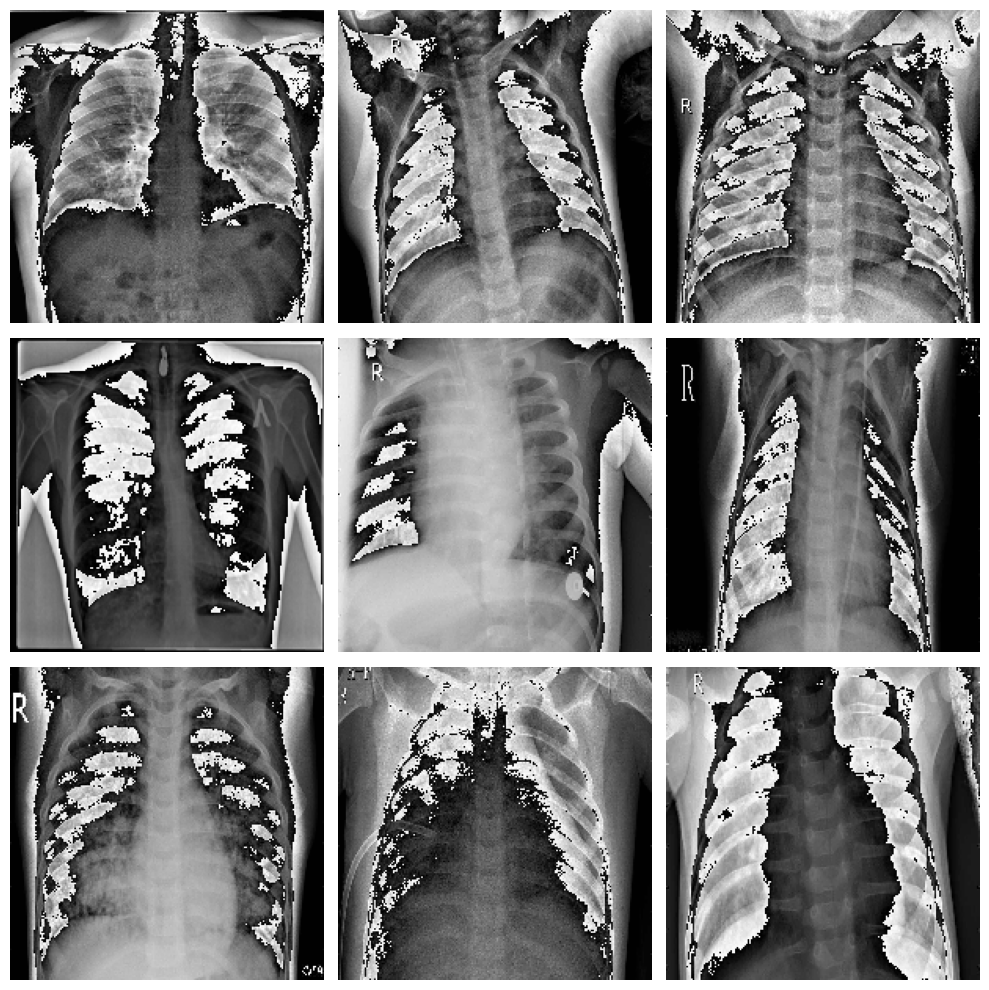

In [39]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample_img = next(train_data)[0][0] * 255
    plt.imshow(sample_img.astype('uint8'))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [40]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [41]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)

In [42]:
for layer in base_model.layers:
    layer.trainable = False

In [43]:
optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
callbacks = [
    ModelCheckpoint(filepath='best_model_densenet.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

In [45]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE
)

Epoch 1/10
315/316 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8497 - loss: 0.4146
Epoch 1: val_loss improved from inf to 0.09196, saving model to best_model_densenet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 79s 193ms/step - accuracy: 0.8500 - loss: 0.4135 - val_accuracy: 1.0000 - val_loss: 0.0920
Epoch 2/10
  1/316 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9375 - loss: 0.1488
Epoch 2: val_loss did not improve from 0.09196
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.9375 - loss: 0.1488 - val_accuracy: 1.0000 - val_loss: 0.0927
Epoch 3/10
315/316 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9514 - loss: 0.1287
Epoch 3: val_loss did not improve from 0.09196
316/316 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.9514 - loss: 0.1286 - val_accuracy: 0.8333 - val_loss: 0.1839
Epoch 4/10
  1/316 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 1.0000 - loss: 0.0118
Epoch 4: val_loss did not improve from 0.09196
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 1.0

In [46]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0105
Validation Loss: 0.010465347208082676, Validation Accuracy: 1.0
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 209ms/step - accuracy: 0.9021 - loss: 0.2948
Test Loss: 0.2894023358821869, Test Accuracy: 0.9053177833557129


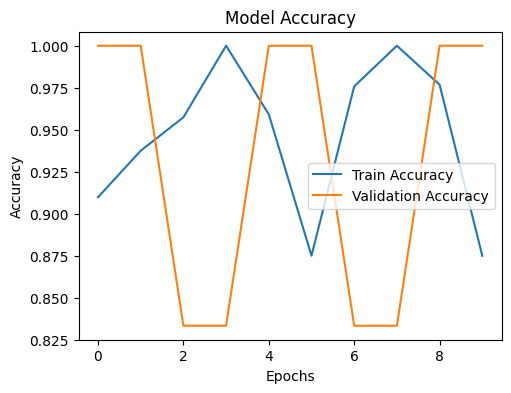

In [47]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

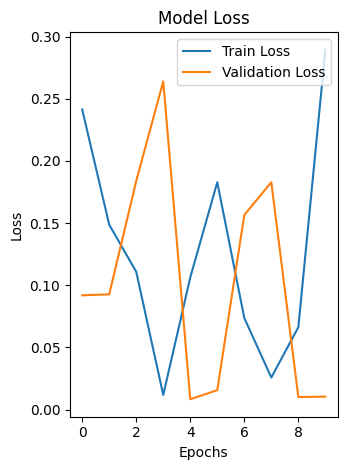

In [48]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
y_pred = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred,axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step


In [50]:
print("Classification Report:")
print(classification_report(test_data.classes, y_pred_classes, target_names=class_labels))

Classification Report:
               precision    recall  f1-score   support

      COVID19       0.96      0.94      0.95       106
       NORMAL       0.87      0.84      0.86       234
    PNEUMONIA       0.91      0.93      0.92       390
TURBERCULOSIS       0.87      0.98      0.92        41

     accuracy                           0.91       771
    macro avg       0.90      0.92      0.91       771
 weighted avg       0.91      0.91      0.91       771



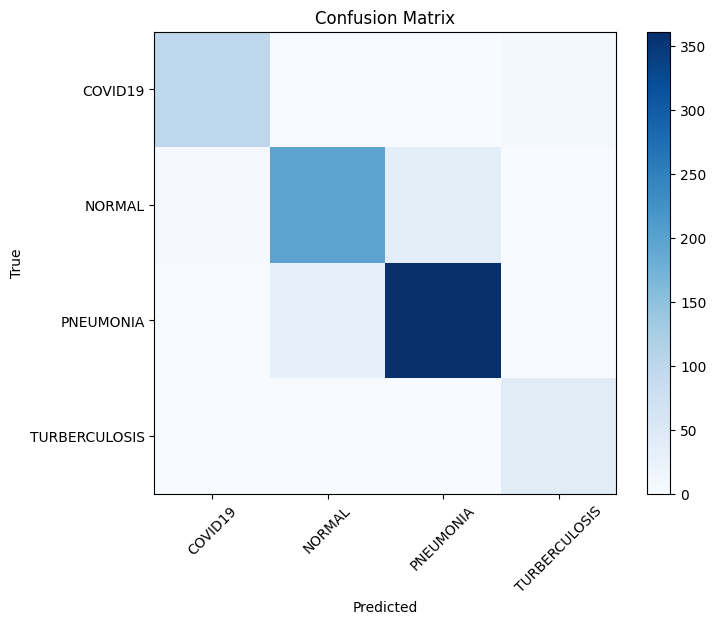

In [51]:
conf_matrix = confusion_matrix(test_data.classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Model saved to disk.


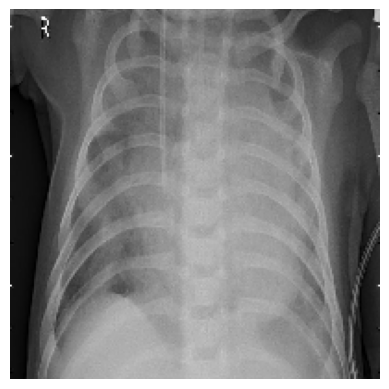

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: PNEUMONIA


In [52]:
model.save("lungs_classification_model_densenet.h5")
print("Model saved to disk.")

# Prediction function
def predict_image(model_path, image_path, class_labels):
    # Load the pre-trained model
    model = load_model("lungs_classification_model_densenet.h5")

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Display the image
    plt.imshow(np.array(img).astype('uint8'))
    plt.axis('off')
    plt.show()

    # Predict the class
    prediction = model.predict(img_array.reshape(1, 200, 200, 3))
    class_index = np.argmax(prediction)
    print(f"Predicted Class: {class_labels[class_index]}")

# Test the prediction function
predict_image("lungs_classification_model_densenet.h5", "/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/PNEUMONIA/person100_bacteria_480.jpeg", class_labels)

## Using Model 2

In [53]:
base_model1 = ResNet152(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [54]:
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model1.input, outputs=output_layer)

In [55]:
for layer in base_model1.layers:
    layer.trainable = False

In [56]:
optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
callbacks = [
    ModelCheckpoint(filepath='best_model_resnet.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

In [58]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE
)

Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6797 - loss: 0.8513
Epoch 1: val_loss improved from inf to 1.44039, saving model to best_model_resnet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 90s 209ms/step - accuracy: 0.6799 - loss: 0.8506 - val_accuracy: 0.5000 - val_loss: 1.4404
Epoch 2/10
  1/316 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - accuracy: 0.8125 - loss: 0.4105
Epoch 2: val_loss improved from 1.44039 to 1.38743, saving model to best_model_resnet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8125 - loss: 0.4105 - val_accuracy: 0.5000 - val_loss: 1.3874
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8346 - loss: 0.4467
Epoch 3: val_loss improved from 1.38743 to 0.83096, saving model to best_model_resnet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 54s 168ms/step - accuracy: 0.8347 - loss: 0.4466 - val_accuracy: 0.6667 - val_loss: 0.8310
Epoch 4/10
  1/316 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.8750 - loss: 0.2546
Epoch 4: val_loss

In [59]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5000 - loss: 1.3363
Validation Loss: 1.33629310131073, Validation Accuracy: 0.5
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.5820 - loss: 1.3617
Test Loss: 1.0439389944076538, Test Accuracy: 0.6835278868675232


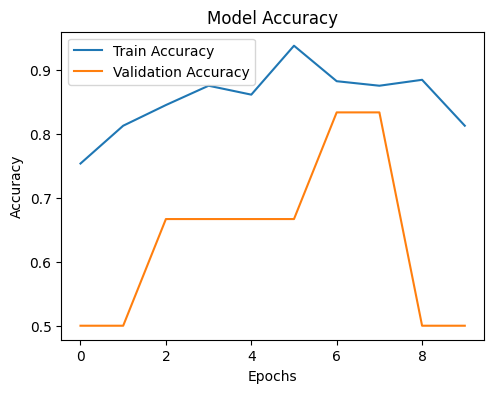

In [60]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

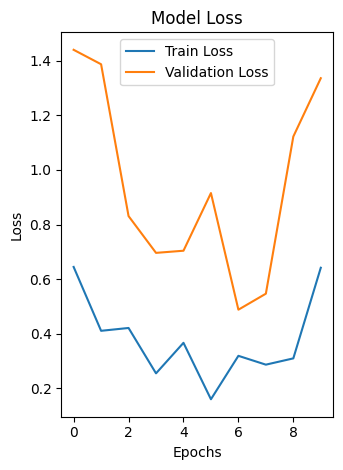

In [61]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
y_pred = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred,axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 310ms/step


In [63]:
print("Classification Report:")
print(classification_report(test_data.classes, y_pred_classes, target_names=class_labels))

Classification Report:
               precision    recall  f1-score   support

      COVID19       0.75      0.77      0.76       106
       NORMAL       0.96      0.18      0.31       234
    PNEUMONIA       0.64      0.99      0.78       390
TURBERCULOSIS       1.00      0.37      0.54        41

     accuracy                           0.68       771
    macro avg       0.84      0.58      0.60       771
 weighted avg       0.77      0.68      0.62       771



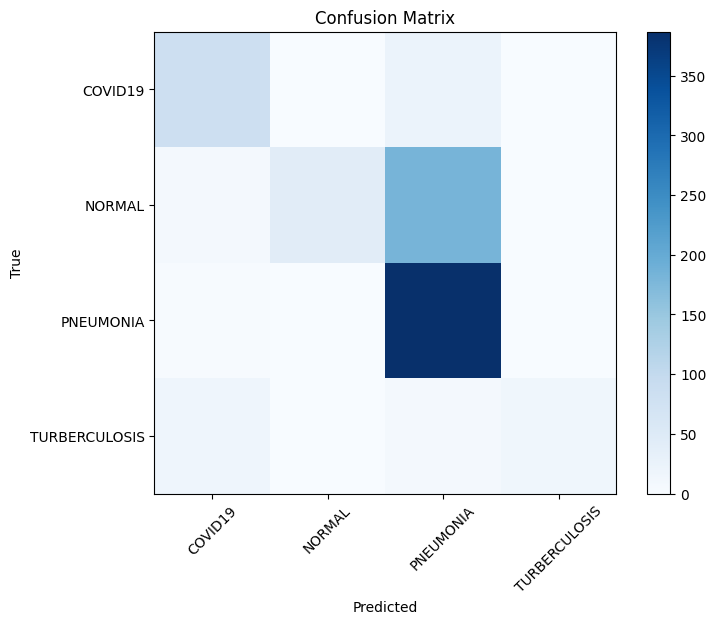

In [64]:
conf_matrix = confusion_matrix(test_data.classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Model saved to disk.


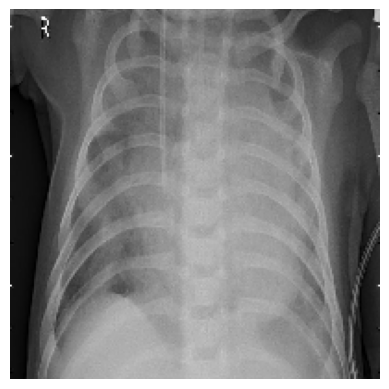

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Class: PNEUMONIA


In [65]:
model.save("lungs_classification_model_resnet.h5")
print("Model saved to disk.")

# Prediction function
def predict_image(model_path, image_path, class_labels):
    # Load the pre-trained model
    model = load_model("lungs_classification_model_resnet.h5")

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Display the image
    plt.imshow(np.array(img).astype('uint8'))
    plt.axis('off')
    plt.show()

    # Predict the class
    prediction = model.predict(img_array.reshape(1, 200, 200, 3))
    class_index = np.argmax(prediction)
    print(f"Predicted Class: {class_labels[class_index]}")

# Test the prediction function
predict_image("lungs_classification_model_resnet.h5", "/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/PNEUMONIA/person100_bacteria_480.jpeg", class_labels)

In [66]:
# import os

# # Specify the file path
# file_path = ['/kaggle/working/best_model_densenet.keras','/kaggle/working/best_model_resnet.keras','/kaggle/working/lungs_classification_model_densenet.h5','/kaggle/working/lungs_classification_model_resnet.h5']

# # Check if the file exists and delete it
# for i in file_path:
#     if os.path.exists(i):
#         os.remove(i)
#         print(f"File {i} has been deleted.")
#     else:
#         print(f"File {i} not found.")
